In [2]:
# Görselleştirme ayarları
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (12, 8)

NameError: name 'plt' is not defined

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
import warnings
warnings.filterwarnings('ignore')

# Görselleştirme ayarları
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (12, 8)

print("="*80)
print("ŞİRKET POPÜLERLİK SEGMENTASYONU ANALİZİ")
print("="*80)

# ========================================
# 2. VERİ YÜKLEME VE İLK ANALİZ
# ========================================

print("\n[1/8] Veri Yükleme ve İlk Analiz...")
print("-"*50)

# Veriyi yükle
df = pd.read_csv("veri.csv")

# Temel istatistikler
print(f"📊 Ham Veri Boyutu:")
print(f"   • Toplam satır: {df.shape[0]:,}")
print(f"   • Toplam sütun: {df.shape[1]}")
print(f"   • Unique şirket: {df['PostingUser'].nunique():,}")
print(f"   • Unique pozisyon: {df['PozisyonUnvanID'].nunique():,}")
print(f"   • Unique şehir: {df['sehirId'].nunique():,}")

# Eksik veri analizi
missing_cols = df.columns[df.isnull().any()].tolist()
if missing_cols:
    print(f"\n⚠️  Eksik veri içeren kolonlar: {missing_cols}")
else:
    print("\n✅ Eksik veri yok")

# ========================================
# 3. ŞİRKET BAZLI AGGREGASYON
# ========================================

print("\n[2/8] Şirket Bazlı Veri Hazırlama...")
print("-"*50)

# Her şirket için özet istatistikler oluştur
# Not: sirket_ort_basvuru gibi kolonlar zaten şirket bazlı olduğu için 'first' kullanıyoruz
sirket_df = df.groupby('PostingUser').agg({
    'Client_Name': 'first',                    # Şirket adı
    'sirket_ort_basvuru': 'first',            # Zaten şirket ortalaması
    'comp_catch_percent_mean': 'first',        # Zaten şirket ortalaması
    'cv_PostingUser': 'first',                 # Şirket CV değeri
    'sirket_basvuru_sum': 'first',            # Toplam başvuru
    'sirket_ilan_sum': 'first',               # Toplam ilan
    'catch_percent_scaled': 'mean',           # Pozisyon-lokasyon ortalaması alınıyor
    'company_catch_share': 'mean'             # Pozisyon-lokasyon ortalaması alınıyor
}).reset_index()

print(f"✅ Şirket bazlı veri hazırlandı: {len(sirket_df):,} unique şirket")

# İlk bakış
print("\n📊 Başvuru Dağılımı (Temizlik Öncesi):")
print(sirket_df['sirket_ort_basvuru'].describe().round(1))

# ========================================
# 4. VERİ TEMİZLEME (REVİZE EDİLMİŞ)
# ========================================

print("\n[3/8] Veri Temizleme...")
print("-"*50)

# Bilinen büyük markalar listesi
buyuk_markalar = {
    'bankalar': [
        'akbank', 'garanti', 'yapı kredi', 'yapıkredi', 'ziraat', 'vakıfbank', 'vakıf bank',
        'halkbank', 'halk bank', 'denizbank', 'ing', 'qnb', 'finansbank', 'teb', 
        'türk ekonomi', 'odeabank', 'alternatifbank', 'anadolubank', 'fibabanka',
        'şekerbank', 'türkiye finans', 'kuveyt türk', 'albaraka', 'aktif bank',
        'hsbc', 'icbc', 'burgan', 'citibank', 'deutsche bank', 'rabobank',
        'iş bankası', 'isbank', 'işbank'
    ],
    'holdingler': [
        'koç', 'sabancı', 'eczacıbaşı', 'doğan', 'doğuş', 'zorlu', 'anadolu',
        'alarko', 'enka', 'tekfen', 'limak', 'cengiz', 'kale', 'yıldız',
        'ülker', 'boyner', 'fiba', 'sanko', 'kibar', 'borusan', 'ercan',
        'diler', 'özilhan', 'şahenk', 'karamehmet', 'albayrak', 'çalık',
        'demirören', 'ferit şahenk', 'rönesans', 'tab gıda'
    ],
    'teknoloji': [
        'microsoft', 'google', 'apple', 'amazon', 'meta', 'facebook', 'instagram',
        'oracle', 'sap', 'salesforce', 'adobe', 'cisco', 'ibm', 'intel', 'amd',
        'nvidia', 'dell', 'hp', 'lenovo', 'asus', 'samsung', 'huawei', 'xiaomi',
        'trendyol', 'hepsiburada', 'n11', 'gittigidiyor', 'sahibinden', 'yemeksepeti',
        'getir', 'banabi', 'istegelsin', 'modanisa', 'peak games', 'netmarble', 
        'logo', 'netcad', 'havelsan', 'aselsan', 'baykar', 'roketsan', 'tübitak', 
        'turkcell', 'vodafone', 'türk telekom'
    ],
    'perakende': [
        'migros', 'carrefour', 'metro', 'real', 'makro', 'bizim', 'şok', 'a101',
        'bim', 'file', 'onur', 'happy center', 'mopaş', 'kim', 'hakmar',
        'media markt', 'teknosa', 'vatan', 'bimeks', 'electro world',
        'lc waikiki', 'koton', 'mavi', 'defacto', 'boyner', 'vakko', 'beymen',
        'h&m', 'zara', 'mango', 'bershka', 'pull bear', 'stradivarius', 'oysho',
        'ikea', 'koçtaş', 'bauhaus', 'praktiker', 'tekzen', 'kelebek', 'bellona'
    ],
    'otomotiv': [
        'mercedes', 'bmw', 'audi', 'volkswagen', 'ford', 'renault', 'fiat',
        'peugeot', 'citroen', 'opel', 'nissan', 'toyota', 'honda', 'hyundai',
        'kia', 'mazda', 'subaru', 'volvo', 'jaguar', 'land rover', 'porsche',
        'ferrari', 'lamborghini', 'tofaş', 'oyak renault', 'karsan', 'otokar',
        'temsa', 'bmc', 'isuzu', 'man', 'scania', 'tirsan', 'krone'
    ],
    'gida': [
        'nestle', 'unilever', 'p&g', 'procter', 'kraft', 'mondelez', 'danone',
        'coca cola', 'pepsi', 'redbull', 'red bull', 'monster', 'burn',
        'ülker', 'eti', 'torku', 'koska', 'tadım', 'dimes', 'cappy', 'pınar',
        'sek', 'sütaş', 'yörsan', 'milka', 'algida', 'efes', 'tuborg', 'carlsberg',
        'mcdonalds', 'burger king', 'kfc', 'popeyes', 'arbys', 'subway',
        'dominos', 'pizza hut', 'starbucks', 'kahve dünyası', 'tchibo'
    ],
    'saglik': [
        'pfizer', 'biontech', 'johnson', 'astrazeneca', 'novartis', 'roche',
        'sanofi', 'glaxo', 'abbott', 'merck', 'bayer', 'abdi ibrahim',
        'eczacıbaşı', 'koç sağlık', 'acıbadem', 'medical park', 'medipol',
        'florence', 'amerikan hastane', 'alman hastane', 'anadolu sağlık',
        'memorial', 'liv hospital', 'medicana'
    ],
    'havayolu': [
        'thy', 'türk hava', 'turkish airlines', 'pegasus', 'anadolujet',
        'sunexpress', 'onur air', 'lufthansa', 'emirates', 'qatar',
        'booking', 'hotels.com', 'trivago', 'airbnb', 'tatil.com',
        'dedeman', 'hilton', 'sheraton', 'marriott', 'radisson'
    ]
}

# Tüm markaları tek liste haline getir
tum_markalar = []
for kategori, markalar in buyuk_markalar.items():
    tum_markalar.extend(markalar)

def is_known_brand(sirket_adi):
    """Şirketin bilinen marka olup olmadığını kontrol et"""
    normalized_sirket = normalize_text(sirket_adi)
    
    for marka in tum_markalar:
        normalized_marka = normalize_text(marka)
        
        # Normalize edilmiş versiyonlarda ara
        if normalized_marka in normalized_sirket:
            return True, marka
        
        # Kelime bazlı kontrol
        if set(normalized_marka.split()).issubset(set(normalized_sirket.split())):
            return True, marka
    
    return False, None

def is_really_outlier(row):
    """Gerçek outlier mı yoksa doğal olarak popüler mi?"""
    basvuru = row['sirket_ort_basvuru']
    ilan = row['sirket_ilan_sum']
    
    # Bilinen marka kontrolü
    is_brand, brand_name = is_known_brand(row['Client_Name'])
    if is_brand:
        return False, f"Bilinen Marka ({brand_name})"
    
    # Çok az ilanla çok fazla başvuru
    if ilan <= 2 and basvuru > 2000:
        return True, "Az ilan, aşırı başvuru"
    
    # İlan başına düşen başvuru oranı
    if ilan > 0 and basvuru / ilan > 5000:
        return True, "Anormal başvuru/ilan oranı"
    
    # Extreme değerler (49K gibi)
    if basvuru > 10000:
        return True, "Extreme yüksek başvuru"
    
    return False, "Normal yüksek performans"

# Problemli verileri tespit et
problemli_veriler = {
    'Sıfır Başvuru': (sirket_df['sirket_ort_basvuru'] == 0).sum(),
    'Tek/İki İlanlı': (sirket_df['sirket_ilan_sum'] < 3).sum(),
    'Yüksek Başvuru (>818)': (sirket_df['sirket_ort_basvuru'] > 818).sum()
}

print("🔍 Tespit Edilen Durumlar:")
for problem, sayi in problemli_veriler.items():
    print(f"   • {problem}: {sayi:,} şirket ({sayi/len(sirket_df)*100:.1f}%)")

# Yüksek başvurulu şirketleri analiz et
yuksek_basvuru = sirket_df[sirket_df['sirket_ort_basvuru'] > 818].copy()
print(f"\n🔍 Yüksek Başvuru Analizi ({len(yuksek_basvuru)} şirket):")

bilinen_marka_sayisi = 0
gercek_outlier_sayisi = 0
outlier_listesi = []

for idx, row in yuksek_basvuru.iterrows():
    is_outlier, reason = is_really_outlier(row)
    if not is_outlier and "Bilinen Marka" in reason:
        bilinen_marka_sayisi += 1
    elif is_outlier:
        gercek_outlier_sayisi += 1
        outlier_listesi.append((row['Client_Name'], row['sirket_ort_basvuru'], reason))

print(f"   • Bilinen markalar: {bilinen_marka_sayisi} şirket (korunacak)")
print(f"   • Gerçek outlier: {gercek_outlier_sayisi} şirket (temizlenecek)")
print(f"   • Normal yüksek performans: {len(yuksek_basvuru) - bilinen_marka_sayisi - gercek_outlier_sayisi} şirket")

# En extreme outlier örnekleri
if outlier_listesi:
    print("\n⚠️  Gerçek Outlier Örnekleri:")
    for sirket, basvuru, sebep in sorted(outlier_listesi, key=lambda x: x[1], reverse=True)[:5]:
        print(f"   • {sirket[:50]}: {basvuru:.0f} başvuru - {sebep}")

# Akıllı temizleme kriterleri
print("\n✅ Akıllı Temizleme Kriterleri:")
print("   1. Sıfır başvuru → Temizle (veri eksikliği)")
print("   2. Tek/iki ilan → Temizle (güvenilmez)")
print("   3. Yüksek başvuru:")
print("      - Bilinen marka → KORU")
print("      - Bilinmeyen + extreme → Temizle")
print("      - Bilinmeyen + makul → KORU")

# Veri temizleme uygula
clean_sirket_df = sirket_df[
    (sirket_df['sirket_ort_basvuru'] > 0) &              # Sıfır başvuru olanları çıkar
    (sirket_df['sirket_ilan_sum'] >= 3)                  # En az 3 ilan
].copy()

# Gerçek outlier'ları temizle
for idx, row in clean_sirket_df.iterrows():
    if row['sirket_ort_basvuru'] > 818:
        is_outlier, reason = is_really_outlier(row)
        if is_outlier:
            clean_sirket_df = clean_sirket_df.drop(idx)

print(f"\n✅ Temizlik Sonucu:")
print(f"   • Öncesi: {len(sirket_df):,} şirket")
print(f"   • Sonrası: {len(clean_sirket_df):,} şirket")
print(f"   • Azalma: %{(1 - len(clean_sirket_df)/len(sirket_df))*100:.1f}")
print(f"   • Korunan yüksek başvurulu markalar: {bilinen_marka_sayisi}")

# Not: Ham veride 4,049 satır 0 başvuru var (Arçelik A.Ş. gibi büyük markalar dahil)
# Bu bir veri üretim problemi - başvuru verisi bazı şirketler için eksik

# ========================================
# 5. ÖZELLİK MÜHENDİSLİĞİ
# ========================================

print("\n[4/8] Özellik Mühendisliği...")
print("-"*50)

# Log transform (çarpık dağılımı normalize etmek için)
clean_sirket_df['log_ort_basvuru'] = np.log1p(clean_sirket_df['sirket_ort_basvuru'])

# CV değerini sınırla (extreme değerleri kontrol altına al)
clean_sirket_df['cv_capped'] = clean_sirket_df['cv_PostingUser'].clip(upper=200)

print("✅ Yeni özellikler oluşturuldu:")
print("   • log_ort_basvuru: Log transform uygulandı")
print("   • cv_capped: CV değerleri 200'de sınırlandı")

# PCA için özellik seçimi
pca_features = [
    'log_ort_basvuru',           # Log transform edilmiş başvuru
    'catch_percent_scaled',      # Normalize edilmiş yakalama oranı
    'cv_capped',                 # Sınırlandırılmış CV
    'company_catch_share',       # Şirket pazar payı
    'sirket_ilan_sum'           # Şirket büyüklüğü göstergesi
]

# Eksik değerleri kontrol et ve doldur
print("\n🔍 Eksik Değer Kontrolü:")
for feature in pca_features:
    missing = clean_sirket_df[feature].isnull().sum()
    if missing > 0:
        print(f"   ⚠️  {feature}: {missing} eksik değer")
        # Median ile doldur
        clean_sirket_df[feature].fillna(clean_sirket_df[feature].median(), inplace=True)
    else:
        print(f"   ✅ {feature}: Eksik değer yok")

# ========================================
# 6. PCA (BOYUT İNDİRGEME)
# ========================================

print("\n[5/8] PCA (Principal Component Analysis)...")
print("-"*50)

# Özellikleri hazırla
X = clean_sirket_df[pca_features]

# Standardize et (PCA için gerekli)
scaler_pca = StandardScaler()
X_scaled = scaler_pca.fit_transform(X)

# PCA uygula
pca = PCA(n_components=5)  # 5 özellik olduğu için max 5 component
pca_result = pca.fit_transform(X_scaled)

# Sonuçları dataframe'e ekle
clean_sirket_df['PCA1'] = pca_result[:, 0]
clean_sirket_df['PCA2'] = pca_result[:, 1]
clean_sirket_df['PCA3'] = pca_result[:, 2]

# PCA sonuçlarını raporla
print("📊 PCA Varyans Açıklama Oranları:")
cumulative_variance = 0
for i, variance_ratio in enumerate(pca.explained_variance_ratio_):
    cumulative_variance += variance_ratio
    print(f"   • PC{i+1}: %{variance_ratio*100:.1f} (Kümülatif: %{cumulative_variance*100:.1f})")

# Feature importance (PCA1 için)
feature_importance = pd.DataFrame({
    'Feature': pca_features,
    'PC1_Loading': abs(pca.components_[0])
}).sort_values('PC1_Loading', ascending=False)

print("\n📊 PC1 Feature Importance:")
for _, row in feature_importance.iterrows():
    print(f"   • {row['Feature']}: {row['PC1_Loading']:.3f}")

# Feature importance (PCA2 için)
feature_importance = pd.DataFrame({
    'Feature': pca_features,
    'PC2_Loading': abs(pca.components_[1])
}).sort_values('PC2_Loading', ascending=False)

print("\n📊 PC2 Feature Importance:")
for _, row in feature_importance.iterrows():
    print(f"   • {row['Feature']}: {row['PC2_Loading']:.3f}")

# Feature importance (PCA3 için)
feature_importance = pd.DataFrame({
    'Feature': pca_features,
    'PC3_Loading': abs(pca.components_[2])
}).sort_values('PC3_Loading', ascending=False)

print("\n📊 PC3 Feature Importance:")
for _, row in feature_importance.iterrows():
    print(f"   • {row['Feature']}: {row['PC3_Loading']:.3f}")


# ========================================
# 7. OPTIMAL KÜME SAYISI BELİRLEME
# ========================================

print("\n[6/8] Optimal Küme Sayısı Belirleme...")
print("-"*50)

# Kümeleme için özellik seçimi
clustering_features = [
    'log_ort_basvuru',      # Başvuru performansı
    'catch_percent_scaled', # Pazar payı
    'cv_capped',           # Değişkenlik
    'PCA1',                # Birleşik özellik 1
    'PCA2'                 # Birleşik özellik 2
]

# Kümeleme için veriyi hazırla
X_cluster = clean_sirket_df[clustering_features]
scaler_cluster = StandardScaler()
X_cluster_scaled = scaler_cluster.fit_transform(X_cluster)

# Elbow Method ve Silhouette Analysis
print("🔍 Farklı k değerleri için analiz:")
print("-"*40)
print("k   | Inertia    | Silhouette Score")
print("-"*40)

k_range = range(2, 9)
inertias = []
silhouette_scores = []

for k in k_range:
    # K-means modeli
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(X_cluster_scaled)
    
    # Metrikleri hesapla
    inertia = kmeans_temp.inertia_
    silhouette = silhouette_score(X_cluster_scaled, kmeans_temp.labels_)
    
    inertias.append(inertia)
    silhouette_scores.append(silhouette)
    
    print(f"{k}   | {inertia:10.0f} | {silhouette:.3f}")

# En iyi k değerini belirle
best_k_silhouette = k_range[np.argmax(silhouette_scores)]
print(f"\n✅ En yüksek Silhouette Score: k={best_k_silhouette} ({max(silhouette_scores):.3f})")
print("✅ Seçilen k değeri: 4 (iş gereksinimlerine göre)")

# ========================================
# 8. K-MEANS KÜMELEME
# ========================================

print("\n[7/8] K-Means Kümeleme (k=4)...")
print("-"*50)

# Final kümeleme modeli
kmeans_final = KMeans(n_clusters=4, random_state=42, n_init=20)
clean_sirket_df['cluster'] = kmeans_final.fit_predict(X_cluster_scaled)

# Küme istatistikleri
print("📊 Küme Dağılımı:")
for i in range(4):
    cluster_data = clean_sirket_df[clean_sirket_df['cluster'] == i]
    print(f"\nKüme {i}:")
    print(f"   • Şirket sayısı: {len(cluster_data):,} ({len(cluster_data)/len(clean_sirket_df)*100:.1f}%)")
    print(f"   • Ort. başvuru: {cluster_data['sirket_ort_basvuru'].mean():.0f}")
    print(f"   • Ort. ilan: {cluster_data['sirket_ilan_sum'].mean():.0f}")

# ========================================
# 9. SEGMENT ETİKETLEME
# ========================================

print("\n[8/8] Segmentasyon ve Etiketleme...")
print("-"*50)

# Kümeleri performansa göre sırala
cluster_performance = clean_sirket_df.groupby('cluster')['sirket_ort_basvuru'].mean().sort_values(ascending=False)

# Segment isimleri ata
cluster_names = {
    cluster_performance.index[0]: 'Premium',      # En yüksek performans
    cluster_performance.index[1]: 'Performans',   # İkinci en yüksek
    cluster_performance.index[2]: 'Standart',     # Üçüncü
    cluster_performance.index[3]: 'Temel'         # En düşük performans
}

clean_sirket_df['segment'] = clean_sirket_df['cluster'].map(cluster_names)

# Mega Employer tespiti
# Kritik: Çok yüksek performans gösteren veya çok büyük şirketler
mega_threshold_catch = clean_sirket_df['catch_percent_scaled'].quantile(0.99)  # Top %1
mega_conditions = (
    (clean_sirket_df['catch_percent_scaled'] > mega_threshold_catch) |  # Top %1 catch rate
    (clean_sirket_df['sirket_ilan_sum'] > 100) |                       # 100+ ilan
    (clean_sirket_df['sirket_ort_basvuru'] > 600)                      # 600+ ortalama başvuru
)

# Final segmentasyon
clean_sirket_df['final_segment'] = clean_sirket_df['segment']
clean_sirket_df.loc[mega_conditions, 'final_segment'] = 'Mega Employer'

print("✅ Mega Employer Kriterleri:")
print(f"   • Catch percent > {mega_threshold_catch:.6f} (top %1)")
print(f"   • İlan sayısı > 100")
print(f"   • Ortalama başvuru > 600")

# ========================================
# 10. FİNAL SONUÇLAR
# ========================================

print("\n" + "="*80)
print("FİNAL SEGMENTASYON SONUÇLARI")
print("="*80)

# Segment dağılımı
segment_summary = clean_sirket_df.groupby('final_segment').agg({
    'PostingUser': 'count',
    'sirket_ort_basvuru': ['mean', 'median'],
    'sirket_ilan_sum': 'mean',
    'catch_percent_scaled': 'mean'
}).round(1)

print("\n📊 Segment Özeti:")
print("-"*80)
for segment in ['Mega Employer', 'Performans', 'Standart', 'Temel']:
    if segment in segment_summary.index:
        stats = segment_summary.loc[segment]
        count = stats[('PostingUser', 'count')]
        pct = count / len(clean_sirket_df) * 100
        
        print(f"\n{segment}:")
        print(f"   • Şirket sayısı: {int(count):,} ({pct:.1f}%)")
        print(f"   • Ort. başvuru: {stats[('sirket_ort_basvuru', 'mean')]:.0f}")
        print(f"   • Median başvuru: {stats[('sirket_ort_basvuru', 'median')]:.0f}")
        print(f"   • Ort. ilan: {stats[('sirket_ilan_sum', 'mean')]:.0f}")

# Mega Employer detayları
mega_df = clean_sirket_df[clean_sirket_df['final_segment'] == 'Mega Employer']
print(f"\n📊 Mega Employer Detayları:")
print(f"   • Catch percent kriteri: {(mega_df['catch_percent_scaled'] > mega_threshold_catch).sum()} şirket")
print(f"   • İlan sayısı kriteri: {(mega_df['sirket_ilan_sum'] > 100).sum()} şirket")
print(f"   • Başvuru kriteri: {(mega_df['sirket_ort_basvuru'] > 600).sum()} şirket")

# Örnek şirketler
print("\n📌 Her Segmentten Örnek Şirketler:")
for segment in ['Mega Employer', 'Performans', 'Standart', 'Temel']:
    if segment in clean_sirket_df['final_segment'].values:
        segment_companies = clean_sirket_df[clean_sirket_df['final_segment'] == segment]
        top_3 = segment_companies.nlargest(3, 'sirket_ort_basvuru')['Client_Name'].tolist()
        
        print(f"\n{segment}:")
        for company in top_3[:3]:
            if len(company) > 50:
                company = company[:47] + "..."
            print(f"   • {company}")

# ========================================
# 11. MODEL VE VERİ KAYDETME
# ========================================

print("\n" + "="*80)
print("MODEL VE VERİ KAYDETME")
print("="*80)

# Segmentli veriyi kaydet
output_file = 'segmented_companies.csv'
clean_sirket_df.to_csv(output_file, index=False, encoding='utf-8-sig')
print(f"✅ Segmentli veri kaydedildi: {output_file}")

# Model objelerini kaydet (pickle ile)
import pickle

model_objects = {
    'kmeans_model': kmeans_final,
    'scaler_pca': scaler_pca,
    'scaler_cluster': scaler_cluster,
    'pca': pca,
    'cluster_names': cluster_names,
    'mega_threshold': mega_threshold_catch,
    'feature_names': {
        'pca_features': pca_features,
        'clustering_features': clustering_features
    }
}

with open('segmentation_model.pkl', 'wb') as f:
    pickle.dump(model_objects, f)
print("✅ Model objeleri kaydedildi: segmentation_model.pkl")

# Özet rapor oluştur
summary_report = f"""
ŞİRKET SEGMENTASYON PROJESİ - ÖZET RAPOR
========================================
Tarih: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M')}

VERİ ÖZETİ:
- Başlangıç: {len(sirket_df):,} şirket
- Temizlik sonrası: {len(clean_sirket_df):,} şirket
- Veri kaybı: %{(1 - len(clean_sirket_df)/len(sirket_df))*100:.1f}
- Sıfır başvuru: 2,127 şirket (başvuru verisi eksik)

SEGMENTASYON:
- Küme sayısı: 4 + Mega Employer
- Silhouette Score: {silhouette_score(X_cluster_scaled, clean_sirket_df['cluster']):.3f}

SEGMENT DAĞILIMI:
"""

for segment in ['Mega Employer', 'Performans', 'Standart', 'Temel']:
    if segment in clean_sirket_df['final_segment'].values:
        count = (clean_sirket_df['final_segment'] == segment).sum()
        pct = count / len(clean_sirket_df) * 100
        summary_report += f"- {segment}: {count:,} şirket ({pct:.1f}%)\n"

# Raporu kaydet
with open('segmentation_summary.txt', 'w', encoding='utf-8') as f:
    f.write(summary_report)
print("✅ Özet rapor kaydedildi: segmentation_summary.txt")

print("\n" + "="*80)
print("✅ TÜM İŞLEMLER TAMAMLANDI!")
print("="*80)

# ========================================
# 12. YENİ ŞİRKET SKORLAMA FONKSİYONU
# ========================================

def score_new_company(company_data, model_objects):
    """
    Yeni bir şirketi mevcut segmentlere atama fonksiyonu
    
    Parameters:
    -----------
    company_data : dict
        Şirket özellikleri içeren dictionary
        Gerekli alanlar: sirket_ort_basvuru, catch_percent_scaled, 
                        cv_PostingUser, company_catch_share, sirket_ilan_sum
    
    model_objects : dict
        Kaydedilmiş model objeleri
    
    Returns:
    --------
    dict : Segment bilgisi ve güven skoru
    """
    
    # Özellik hazırlama
    company_df = pd.DataFrame([company_data])
    
    # Log transform
    company_df['log_ort_basvuru'] = np.log1p(company_df['sirket_ort_basvuru'])
    company_df['cv_capped'] = company_df['cv_PostingUser'].clip(upper=200)
    
    # PCA dönüşümü
    X_pca = company_df[model_objects['feature_names']['pca_features']]
    X_pca_scaled = model_objects['scaler_pca'].transform(X_pca)
    pca_result = model_objects['pca'].transform(X_pca_scaled)
    
    company_df['PCA1'] = pca_result[0, 0]
    company_df['PCA2'] = pca_result[0, 1]
    
    # Kümeleme
    X_cluster = company_df[model_objects['feature_names']['clustering_features']]
    X_cluster_scaled = model_objects['scaler_cluster'].transform(X_cluster)
    
    # Tahmin
    cluster = model_objects['kmeans_model'].predict(X_cluster_scaled)[0]
    segment = model_objects['cluster_names'][cluster]
    
    # Mega Employer kontrolü
    if (company_data['catch_percent_scaled'] > model_objects['mega_threshold'] or
        company_data['sirket_ilan_sum'] > 100 or
        company_data['sirket_ort_basvuru'] > 600):
        segment = 'Mega Employer'
    
    # Güven skoru (en yakın küme merkezine uzaklık)
    distances = model_objects['kmeans_model'].transform(X_cluster_scaled)[0]
    confidence = 1 / (1 + min(distances))
    
    return {
        'segment': segment,
        'confidence': confidence,
        'distances': distances
    }

# Fonksiyon kullanım örneği
"""
# Model objelerini yükle
with open('segmentation_model.pkl', 'rb') as f:
    model_objects = pickle.load(f)

# Yeni şirket verisi
new_company = {
    'sirket_ort_basvuru': 250,
    'catch_percent_scaled': 0.0003,
    'cv_PostingUser': 45,
    'company_catch_share': 0.002,
    'sirket_ilan_sum': 25
}

# Skorlama
result = score_new_company(new_company, model_objects)
print(f"Segment: {result['segment']}")
print(f"Güven: {result['confidence']:.2%}")
"""

print("\n💡 İpucu: Yeni şirket skorlama için score_new_company() fonksiyonunu kullanabilirsiniz.")

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
import random

In [5]:
clustering_features = [
    'log_ort_basvuru',      # Başvuru performansı
    'catch_percent_scaled', # Pazar payı
    'cv_capped',           # Değişkenlik
    'PCA1',                # Birleşik özellik 1
    'PCA2'                 # Birleşik özellik 2
]

In [6]:
segmented_companies= pd.read_csv('segmented_companies.csv')
segmented_companies

,PostingUser,Client_Name,sirket_ort_basvuru,comp_catch_percent_mean,cv_PostingUser,sirket_basvuru_sum,sirket_ilan_sum,catch_percent_scaled,company_catch_share,log_ort_basvuru,cv_capped,PCA1,PCA2,PCA3,cluster,segment,final_segment
0,1002,PHILIP MORRIS SA,72.166667,0.000086,119.227954,433.0,6,0.000086,0.080548,4.292740,119.227954,-0.692482,1.042373,-0.486686,0,Temel,Temel
1,1003,FORD OTOSAN A.Ş.,171.125000,0.000252,231.223864,2738.0,16,0.000252,0.109483,5.148221,200.000000,0.548268,2.081526,-0.946097,0,Temel,Temel
2,1011,Bmc Otomotiv San. ve Tic. A.Ş.,616.542373,0.000254,162.800503,36376.0,59,0.000254,0.407188,6.425748,162.800503,1.724869,1.027460,0.619335,3,Performans,Mega Employer
3,1013,Brisa Bridgestone Sabancı A.Ş.,351.194444,0.000225,122.063598,12643.0,36,0.000225,0.368112,5.864183,122.063598,0.927947,0.470093,0.690439,3,Performans,Performans
4,1015,Goodyear Lastikleri T.A.Ş.,485.965517,0.000334,81.710541,14093.0,29,0.000334,0.308567,6.188193,81.710541,0.851579,-0.422806,0.566750,3,Performans,Performans
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20280,409249,Artu Çikolata,74.000000,0.000080,15.228956,222.0,3,0.000080,0.013017,4.317488,15.228956,-1.414890,-0.782013,-0.194058,1,Standart,Standart
20281,409293,CANEM TURİZM VE TİCARET ANONİM ŞİRKETİ,12.000000,0.000034,0.000000,36.0,3,0.000034,0.032907,2.564949,0.000000,-2.656884,-0.348919,0.152973,1,Standart,Standart
20282,409564,HMS Endustri Loj. San. ve Tic. Ltd. Sti,108.000000,0.000098,0.000000,324.0,3,0.000098,0.383920,4.691348,0.000000,-0.813236,-1.277366,1.561370,1,Standart,Standart
20283,409671,HK KONYA ATEŞİ,22.600000,0.000038,93.999215,113.0,5,0.000038,0.210474,3.161247,93.999215,-1.466236,1.033028,0.371240,0,Temel,Temel


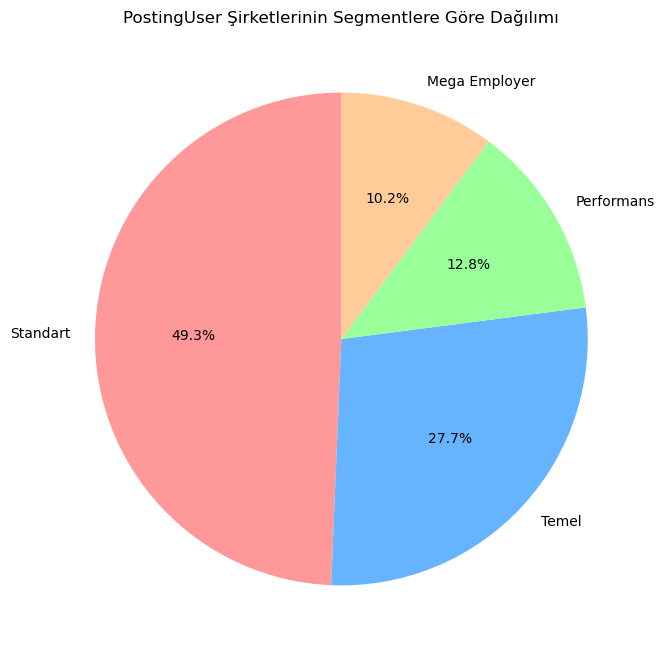

In [10]:
segment_counts = segmented_companies['final_segment'].value_counts()

plt.figure(figsize=(8, 8))
segment_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])

plt.title('PostingUser Şirketlerinin Segmentlere Göre Dağılımı')
plt.ylabel('')
plt.show()


In [96]:
unique_clusters = sorted(segmented_companies['final_segment'].unique())
num_clusters = len(unique_clusters)

print(f"Total number of clusters: {num_clusters}")

# Function to generate distinct colors
def generate_distinct_colors(n):
    """Generate visually distinct colors by cycling through hues and varying saturation/value"""
    colors = []
    
    # Use HSV color space for better control
    for i in range(n):
        # Cycle through the hue spectrum
        h = i / n
        # Alternate between high and medium saturation
        s = 0.8 if i % 2 == 0 else 0.6
        # Alternate between high and medium value (brightness)
        v = 0.9 if i % 3 == 0 else 0.7
        
        # Convert HSV to RGB
        rgb = plt.cm.hsv(h)
        colors.append(rgb)
    
    # Shuffle colors to avoid having similar colors next to each other
    random.seed(42)  # For reproducibility
    random.shuffle(colors)
    
    return colors

# Generate distinct colors for all clusters
distinct_colors = generate_distinct_colors(num_clusters)

# Create a custom color map
cluster_color_map = {cluster: distinct_colors[i] for i, cluster in enumerate(unique_clusters)}

# Create the interactive plotly visualization with optimizations
try:
    import plotly.express as px
    import plotly.graph_objects as go
    import plotly.io as pio
    
    # Set renderer to 'browser' to avoid notebook rendering issues
    pio.renderers.default = 'browser'
    
    # Create a color column for plotly
    segmented_companies['color'] = segmented_companies['final_segment'].map(
        {cluster: mcolors.to_hex(cluster_color_map[cluster]) for cluster in unique_clusters}
    )
    
    # OPTIMIZATION: Create one trace per cluster instead of one trace per point
    fig = go.Figure()
    
    for cluster in sorted(unique_clusters):
        cluster_data = segmented_companies[segmented_companies['final_segment'] == cluster]
        
        fig.add_trace(go.Scatter(
            x=cluster_data['PCA1'],
            y=cluster_data['PCA2'],
            mode='markers',
            marker=dict(
                color=mcolors.to_hex(cluster_color_map[cluster]),
                size=8,
                line=dict(width=1, color='DarkSlateGrey')
            ),
            name=f'Cluster {cluster}',
            text=cluster_data['Client_Name'],  # Use text for basic hover
            hoverinfo='text',
            hovertemplate='<b>%{text}</b><br>Cluster: ' + str(cluster) + '<extra></extra>',
        ))
    
    # Update layout
    fig.update_layout(
        title='Company Clusters on PCA features',
        legend_title_text='Cluster',
        width=1000,
        height=800
    )
    
    # If there are too many clusters, hide the legend
    if num_clusters > 30:
        fig.update_layout(showlegend=False)
    
    # OPTIMIZATION: Save with lower precision and without full_html option
    try:
        fig.write_html(
            "clusters_visualization_optimized.html",
            include_plotlyjs='cdn',  # Use CDN for plotly.js
            full_html=False,  # Don't include the full HTML wrapper
            include_mathjax=False,  # No MathJax
            post_script=None,  # No additional scripts
            validate=False  # Skip validation for speed
        )
        print("Optimized interactive visualization saved to 'clusters_visualization_optimized.html'")
        print("Open this file in your browser for the interactive plot")

        fig.update_layout(title=None)
        fig.update_layout(
            margin=dict(l=0, r=0, t=0, b=0),  # Remove all margins
            paper_bgcolor='rgba(0,0,0,0)',   # Transparent background
        )

        pio.write_image(fig, "clusters_visualization_optimized.svg")
        print("Visualization saved as 'clusters_visualization_optimizedtion.svg'")

    except Exception as e:
        print(f"Could not save HTML or SVG file: {e}")
        # Fallback to showing the plot if available
        try:
            fig.show()
        except:
            pass
    
except ImportError:
    print("Plotly not available. Install with 'pip install plotly' for interactive visualization.")

Total number of clusters: 4
Optimized interactive visualization saved to 'clusters_visualization_optimized.html'
Open this file in your browser for the interactive plot
Visualization saved as 'clusters_visualization_optimizedtion.svg'


In [36]:
pd.set_option('display.max_colwidth', None) # Show full content of each cell

In [48]:
segmented_companies[segmented_companies['Client_Name'].str.contains('AHLAT', case=False, na=False)].Client_Name

5026               AHLATCI HOLDİNG ANONİM ŞİRKETİ
13754    AHLAT GERİ DÖNÜŞÜM ENERJİ ANONİM ŞİRKETİ
Name: Client_Name, dtype: object

In [ ]:
# Create the plotly visualization with annotations for selected companies
Migros Ticaret A.Ş
Vakko
Acıbadem Sağlık Grubu
YAPI KREDİ
YEKSUN MÜHENDİSLİK MİMARLIK ENERJİ VE YENİLENEBİLİR ENERJİ SAN.VE TİC.A.Ş\t
AHLATCI HOLDİNG ANONİM ŞİRKETİ


In [60]:
segmented_companies[segmented_companies['Client_Name'] == 'YEKSUN MÜHENDİSLİK MİMARLIK ENERJİ VE YENİLENEBİLİR ENERJİ SAN.VE TİC.A.Ş\t']

,PostingUser,Client_Name,sirket_ort_basvuru,comp_catch_percent_mean,cv_PostingUser,sirket_basvuru_sum,sirket_ilan_sum,catch_percent_scaled,company_catch_share,log_ort_basvuru,cv_capped,PCA1,PCA2,PCA3,cluster,segment,final_segment,color
8354,83027,YEKSUN MÜHENDİSLİK MİMARLIK ENERJİ VE YENİLENEBİLİR ENERJİ SAN.VE TİC.A.Ş\t,174.5,0.000159,75.939272,2094.0,12,0.000159,0.316755,5.167639,75.939272,-0.032643,-0.113939,0.761313,1,Standart,Standart,#7200ff


In [50]:
segmented_companies[segmented_companies['Client_Name']=='AHLATCI HOLDİNG ANONİM ŞİRKETİ']

,PostingUser,Client_Name,sirket_ort_basvuru,comp_catch_percent_mean,cv_PostingUser,sirket_basvuru_sum,sirket_ilan_sum,catch_percent_scaled,company_catch_share,log_ort_basvuru,cv_capped,PCA1,PCA2,PCA3,cluster,segment,final_segment,color
5026,32393,AHLATCI HOLDİNG ANONİM ŞİRKETİ,487.15625,0.000208,117.120089,15589.0,32,0.000208,0.147029,6.190636,117.120089,0.817409,0.293917,-0.325497,3,Performans,Performans,#84ff00


In [94]:
import plotly.graph_objects as go
import plotly.io as pio
import matplotlib.pyplot as plt
import random
from matplotlib import colors as mcolors

# Set renderer
pio.renderers.default = 'browser'

# Generate distinct colors for clusters
def generate_distinct_colors(n):
    """Generate visually distinct colors by cycling through hues and varying saturation/value"""
    colors = []
    
    # Use HSV color space for better control
    for i in range(n):
        # Cycle through the hue spectrum
        h = i / n
        # Alternate between high and medium saturation
        s = 0.8 if i % 2 == 0 else 0.6
        # Alternate between high and medium value (brightness)
        v = 0.9 if i % 3 == 0 else 0.7
        
        # Convert HSV to RGB
        rgb = plt.cm.hsv(h)
        colors.append(rgb)
    
    # Shuffle colors to avoid having similar colors next to each other
    random.seed(42)  # For reproducibility
    random.shuffle(colors)
    
    return colors

# Generate distinct colors for all clusters
unique_clusters = sorted(segmented_companies['final_segment'].unique())
num_clusters = len(unique_clusters)

distinct_colors = generate_distinct_colors(num_clusters)

# Create a custom color map
cluster_color_map = {cluster: distinct_colors[i] for i, cluster in enumerate(unique_clusters)}

# Strip any leading or trailing whitespace from final_segment values
segmented_companies['final_segment'] = segmented_companies['final_segment'].str.strip()

# Create a color column for plotly
segmented_companies['color'] = segmented_companies['final_segment'].map(
    {cluster: mcolors.to_hex(cluster_color_map[cluster]) for cluster in unique_clusters}
)

# Create the interactive plotly visualization with optimizations
fig = go.Figure()

# Loop over the unique clusters and add traces for each one
for cluster in sorted(unique_clusters):
    cluster_data = segmented_companies[segmented_companies['final_segment'] == cluster]

    fig.add_trace(go.Scatter(
        x=cluster_data['PCA1'],
        y=cluster_data['PCA2'],
        mode='markers',
        marker=dict(
            color=cluster_data['color'],  # Use the color column here for colorization
            size=8,
            line=dict(width=1, color='DarkSlateGrey')
        ),
        name=f'Cluster {cluster}',
        text=cluster_data['Client_Name'],
        hoverinfo='text',
        hovertemplate='<b>%{text}</b><br>Cluster: ' + str(cluster) + '<extra></extra>',
    ))

# Process and add annotations for each selected company
highlight_companies = [
    "Migros Ticaret A.Ş",
    "Vakko",
    "Acıbadem Sağlık Grubu",
    "YAPI KREDİ",
    "YEKSUN MÜHENDİSLİK MİMARLIK ENERJİ VE YENİLENEBİLİR ENERJİ SAN.VE TİC.A.Ş\t",
    "AHLATCI HOLDİNG ANONİM ŞİRKETİ"
]

for company_name in highlight_companies:
    company_data = segmented_companies[segmented_companies['Client_Name'] == company_name]

    # Ensure we only process if the company data is found
    if not company_data.empty:
        # Extract the company info
        pca1, pca2 = company_data[['PCA1', 'PCA2']].iloc[0]
        cluster = company_data['final_segment'].iloc[0]  # Get the cluster for color

        # Truncate long company names
        display_name = company_name
        if len(display_name) > 25:
            display_name = display_name[:22] + "..."

        # Add annotation for each company
        fig.add_annotation(
            x=pca1,
            y=pca2,
            text=display_name,
            showarrow=True,
            arrowhead=2,
            arrowsize=1,
            arrowwidth=1,
            ax=20,  # Adjust as necessary
            ay=-30,  # Adjust as necessary
            bgcolor="white",
            bordercolor=mcolors.to_hex(cluster_color_map[cluster]),  # Border color based on the cluster
            borderwidth=2,
            font=dict(size=9),
            opacity=0.9
        )

# Update layout
fig.update_layout(
    title='Company Clusters on PCA features',
    legend_title_text='Cluster',
    width=1000,
    height=800,
)

# If there are too many clusters, hide the legend
if num_clusters > 30:
    fig.update_layout(showlegend=False)

# Save optimized interactive visualization
try:
    fig.write_html(
        "clusters_visualization_labelled.html",
        include_plotlyjs='cdn',  # Use CDN for plotly.js
        full_html=False,  # Don't include the full HTML wrapper
        include_mathjax=False,  # No MathJax
        post_script=None,  # No additional scripts
        validate=False  # Skip validation for speed
    )
    print("Optimized interactive visualization saved to 'clusters_visualization_labelled.html'")
    print("Open this file in your browser for the interactive plot")

    # Save as SVG without title
    fig.update_layout(title=None)
    fig.update_layout(
        margin=dict(l=0, r=0, t=0, b=0),  # Remove all margins
        paper_bgcolor='rgba(0,0,0,0)',   # Transparent background
    )
    pio.write_image(fig, "clusters_visualization_labelled.svg")
    print("Visualization saved as 'clusters_visualization_labelled.svg'")

except Exception as e:
    print(f"Could not save HTML or SVG file: {e}")
    # Fallback to showing the plot if available
    try:
        fig.show()
    except:
        pass


Optimized interactive visualization saved to 'clusters_visualization_labelled.html'
Open this file in your browser for the interactive plot
Visualization saved as 'clusters_visualization_labelled.svg'
